# WordCloud borrador constitución política 14-mayo-2022


### Instalar e importar librerías
Comenzamos importando todas las librerías necesarias para el análisis de texto.

In [1]:
#Librerías para abrir y leer pdf
import pdfminer
import io
from pdfminer.converter import TextConverter
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfpage import PDFPage

#Librerías básicas utilizadas
import numpy as np
import pandas as pd
import matplotlib

#Librerías necesarias para abrir imágenes, generar nube de palabras y plot
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
#matplotlib.use('SVG') #set the backend to SVG

#Librerías necesarias para la limpieza de datos
import string
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords') #Si es primera vez utilizando stopwords, estas deben descargarse

Se define la función _extract_text_from_pdf_ que nos ayudará a extraer el texto completo del pdf a analizar. 

In [2]:
def extract_text_from_pdf(pdf_path):
    resource_manager = PDFResourceManager()
    fake_file_handle = io.StringIO()
    converter = TextConverter(resource_manager, fake_file_handle)
    page_interpreter = PDFPageInterpreter(resource_manager, converter)
    with open(pdf_path, 'rb') as fh:
        for page in PDFPage.get_pages(fh, 
                                      caching=True,
                                      check_extractable=True):
            page_interpreter.process_page(page)
        texto = fake_file_handle.getvalue()
    # close open handles
    converter.close()
    fake_file_handle.close()
    if texto:
        return texto

### Extracción del texto pdf
El archivo pdf lo puedes encontrar en https://www.chileconvencion.cl/wp-content/uploads/2022/05/PROPUESTA-DE-BORRADOR-CONSTITUCIONAL-14.05.22.pdf

In [3]:
import urllib.request
url = 'https://www.chileconvencion.cl/wp-content/uploads/2022/05/PROPUESTA-DE-BORRADOR-CONSTITUCIONAL-14.05.22.pdf'
urllib.request.urlretrieve(url, "Borrador_constitución_14-mayo-2022.pdf")

('Borrador_constitución_14-mayo.2022.pdf',
 <http.client.HTTPMessage at 0x1b70a8efa00>)

In [4]:
texto = extract_text_from_pdf(r'Borrador_constitución_14-mayo-2022.pdf')
texto[:500]

' • Este documento es un consolidado que reúne las normas aprobadas por el Pleno de la Convención Constitucional, ordenadas por comisión. La relación de números de los artículos obedece a lo dispuesto en los respectivos informes y no es el orden definitivo, ya que ese proceso deberá ser realizado por la Comisión de Armonización (Actualizado el 14.05.22).   CONSOLIDADO NORMAS APROBADAS PARA LA PROPUESTA CONSTITUCIONAL POR EL PLENO DE LA CONVENCIÓN  CAPÍTULO (COM 1) DE LA DEMOCRACIA  1.- Artículo 2'

### Procesamiento del texto
Nos damos cuenta que hay palabras irrelevantes, stopwords, link y signos de puntuación que deben eliminarse para obtener sólo la información que nos interesa. 

In [5]:
#Generación de lista de signos de puntuación
punctuation=[]
for s in string.punctuation:
    punctuation.append(str(s))
sp_punctuation = ["¿", "¡", "“", "”", "…", ":", "–", "»", "«"]    
punctuation += sp_punctuation

#nltk.download('stopwords') #La primera vez debemos descargar las "stopwords"
stop_words = stopwords.words('spanish') #Listado de palabras a eliminar
stop_words += ["artículo", "para", "como", "puede","cómo", "hacer", "forma", "parte", "hace",
               "además", "según", "pueden", "ser", "así", "podrá", "deberá", "podrán", "demás", 
              "deberán"] #Añadimos algunos caractéres que hemos encontrado

#Reemplazamos signos de puntuación por "":
for p in punctuation:
    clean_texto = texto.lower().replace(p,"")
for p in punctuation:
    clean_texto = clean_texto.replace(p,"")
    
#Eliminamos espacios blancos, saltos de línea, tabuladores, etc    
clean_texto = " ".join(clean_texto.split())   

#Reemplazamos stop_words por "":    
for stop in stop_words:
    clean_texto_list = clean_texto.split()
    clean_texto_list = [i.strip() for i in clean_texto_list]
    try:
        while stop in clean_texto_list: clean_texto_list.remove(stop)
    except:
        print("Error")
        pass
    clean_texto= " ".join(clean_texto_list)
    
#Paso intermedio para eliminar palabras muy cortas (emoticonos,etc) y muy largas (ulr o similar) que se nos hayan pasado:
lista_texto = clean_texto.split(" ")
palabras = []

for palabra in lista_texto:
    if (len(palabra)>=3 and len(palabra)<18):
        palabras.append(palabra)

In [6]:
clean_texto[:500]

'• documento consolidado reúne normas aprobadas pleno convención constitucional ordenadas comisión relación números artículos obedece dispuesto respectivos informes orden definitivo proceso realizado comisión armonización actualizado 140522 consolidado normas aprobadas propuesta constitucional pleno convención capítulo com 1 democracia 1 2° democracia paritaria reconoce promueve sociedad mujeres hombres diversidades disidencias sexogenéricas participen condiciones igualdad sustantiva reconociendo'

### Análisis de texto
Se contabilizan las palabras para luego realizar la nube de palabras más frecuentes

In [7]:
#Generamos un diccionario para contabilizar las palabras:
word_count={}

for palabra in palabras:
    if palabra in word_count.keys():
        word_count[palabra][0]+=1
    else:
        word_count[palabra]=[1]
        
#Generamos el DF y lo ordenamos:
df = pd.DataFrame.from_dict(word_count).transpose()
df.columns=["freq"]
df.sort_values(["freq"], ascending=False, inplace=True)
df.head(7)

,freq
ley,486
derecho,255
constitución,252
derechos,209
personas,155
ejercicio,145
regional,144


### Generamos la nube de la palabras

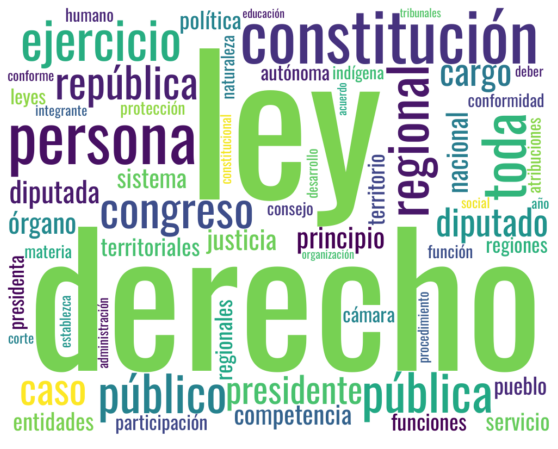

In [8]:
font = 'Oswald-VariableFont_wght.ttf'
word_cloud = WordCloud(height=800, width=1000, background_color='white',max_words=60,
                       min_font_size=5, collocation_threshold=30, collocations=False,
                      font_path = font, random_state=11).generate(clean_texto) 

fname = "WordCloud_Constitución.png"
plt.imshow(word_cloud, interpolation="bilinear") 
plt.axis("off")
fig = plt.gcf() #get current figure
fig.set_size_inches(10,8)  
plt.savefig(fname)

In [9]:
#Para obtener código .svg
word_cloud.to_svg(embed_font=True)